In [26]:
# Phase 1: Data Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv(r"C:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 01\bank-full(1).csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [72]:
## 1.1 Data Cleaning
#We start by identifying missing values (NaN) and placeholder values such as 'unknown' in the dataset. We summarize the number of such values in each column and explain the strategy for handling them.

In [27]:
# Identify missing and 'unknown' values
missing_summary = pd.DataFrame({
    'missing': df.isnull().sum(),
    'unknown': (df == 'unknown').sum(),
    'total_problematic': df.isnull().sum() + (df == 'unknown').sum()
})
print(missing_summary)

# Do not remove or replace 'unknown' values, just keep the original dataframe
df_cleaned = df.copy()
df_cleaned.head()


           missing  unknown  total_problematic
age              0        0                  0
job              0      288                288
marital          0        0                  0
education        0     1857               1857
default          0        0                  0
balance          0        0                  0
housing          0        0                  0
loan             0        0                  0
contact          0    13020              13020
day              0        0                  0
month            0        0                  0
duration         0        0                  0
campaign         0        0                  0
pdays            0        0                  0
previous         0        0                  0
poutcome         0    36959              36959
y                0        0                  0


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [13]:
## 1.1 Feature Categorization
# We categorize each feature as either numerical or categorical. The table below lists each feature, its type, and a brief description.

In [28]:
# Categorize features
feature_types = pd.DataFrame({
    'feature': df_cleaned.columns,
    'type': ['numerical' if np.issubdtype(df_cleaned[col].dtype, np.number) else 'categorical' for col in df_cleaned.columns],
    'description': [
        'Client age', 'Job type', 'Marital status', 'Education level', 'Default on credit', 'Average balance', 'Has housing loan',
        'Has personal loan', 'Contact communication type', 'Last contact month', 'Last contact day', 'Duration of last contact',
        'Number of contacts during campaign', 'Days since last contact', 'Number of previous contacts', 'Outcome of previous campaign',
        'Subscribed to term deposit'
    ]
})
feature_types

,feature,type,description
0,age,numerical,Client age
1,job,categorical,Job type
2,marital,categorical,Marital status
3,education,categorical,Education level
4,default,categorical,Default on credit
5,balance,numerical,Average balance
6,housing,categorical,Has housing loan
7,loan,categorical,Has personal loan
8,contact,categorical,Contact communication type
9,day,numerical,Last contact month


In [15]:
## 1.2 Feature Engineering: New Features
# We create two new features to enhance model performance. Each feature is explained below.

In [29]:
# Feature 1: Age Group
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[17, 30, 45, 60, 100], labels=['Young', 'Adult', 'Senior', 'Elder'])
# Purpose: Groups clients by age for better segmentation. Age group may influence likelihood to subscribe.

# Feature 2: Contacted Before (binary)
df_cleaned['contacted_before'] = np.where((df_cleaned['pdays'] != -1), 1, 0)
# Purpose: Indicates if client was previously contacted. Prior contact may affect subscription probability.
# Using both 'previous' and 'pdays' to determine if contacted before. / pdays = -1 indicates never contacted.

# Display sample of updated data
df_cleaned[['age', 'age_group', 'previous', 'contacted_before', 'y']].head()



,age,age_group,previous,contacted_before,y
0,58,Senior,0,0,no
1,44,Adult,0,0,no
2,33,Adult,0,0,no
3,47,Senior,0,0,no
4,33,Adult,0,0,no


In [17]:
## 1.3 Basic Statistics and Correlation Analysis
# We compute summary statistics for numerical features and analyze correlations to guide feature selection and modeling.

                    count         mean          std     min    25%    50%  \
age               45211.0    40.936210    10.618762    18.0   33.0   39.0   
balance           45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0   
day               45211.0    15.806419     8.322476     1.0    8.0   16.0   
duration          45211.0   258.163080   257.527812     0.0  103.0  180.0   
campaign          45211.0     2.763841     3.098021     1.0    1.0    2.0   
pdays             45211.0    40.197828   100.128746    -1.0   -1.0   -1.0   
previous          45211.0     0.580323     2.303441     0.0    0.0    0.0   
contacted_before  45211.0     0.182633     0.386369     0.0    0.0    0.0   

                     75%       max  
age                 48.0      95.0  
balance           1428.0  102127.0  
day                 21.0      31.0  
duration           319.0    4918.0  
campaign             3.0      63.0  
pdays               -1.0     871.0  
previous             0.0     275.0  
contacted_

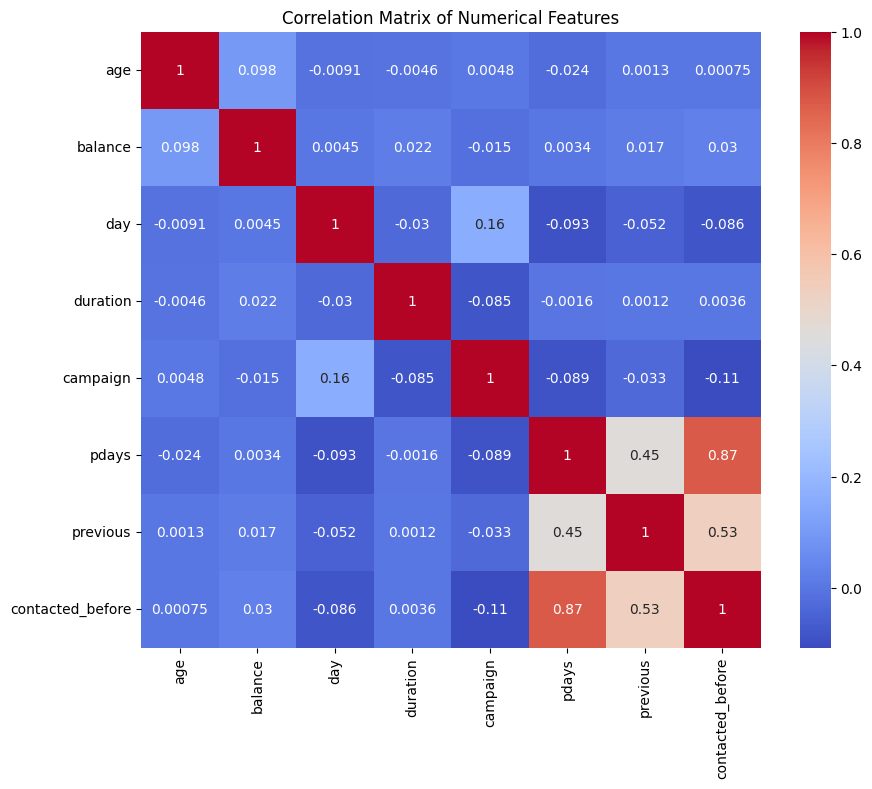

In [30]:
# Summary statistics for numerical features
num_features = df_cleaned.select_dtypes(include=[np.number]).columns
summary_stats = df_cleaned[num_features].describe().T
print(summary_stats)

# Correlation matrix
corr_matrix = df_cleaned[num_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [36]:
## 1.4 Data Visualisation
# We use histograms, bar charts, boxplots, and heatmaps to explore data distributions and relationships with the target variable.
df_cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,contacted_before
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,Senior,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,Adult,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,Adult,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,Senior,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,Adult,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes,Senior,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes,Elder,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,Elder,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no,Senior,0


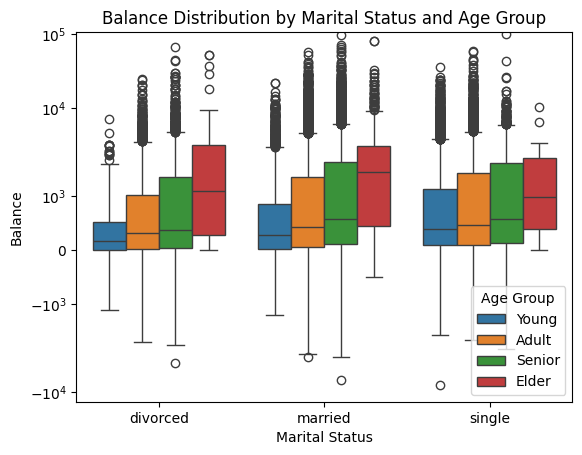

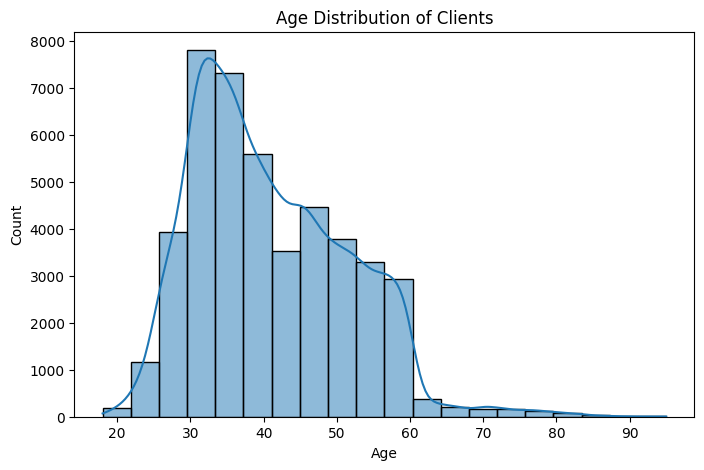

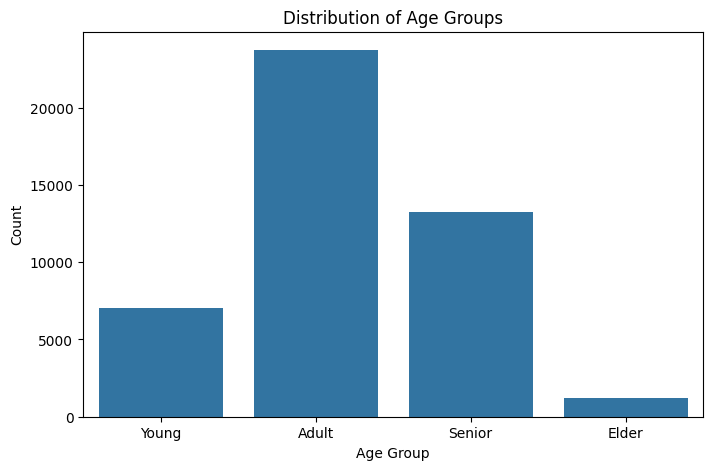

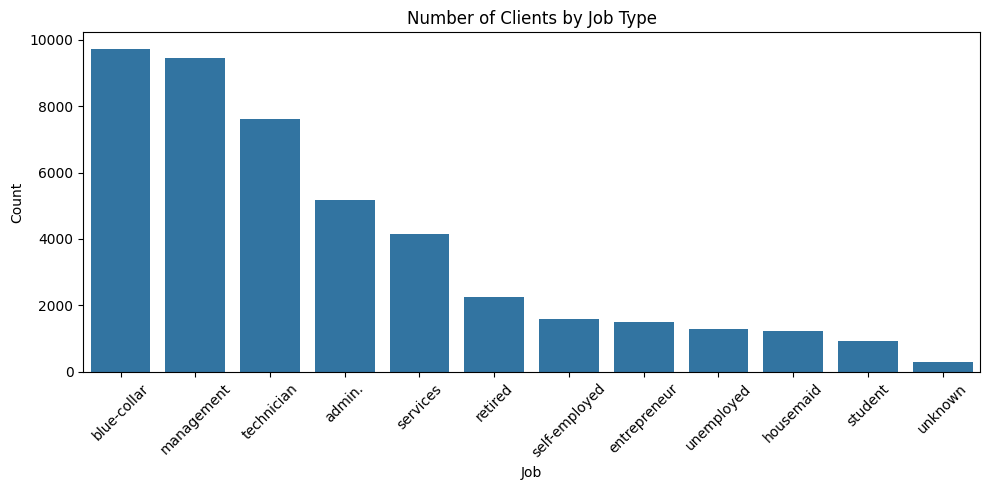

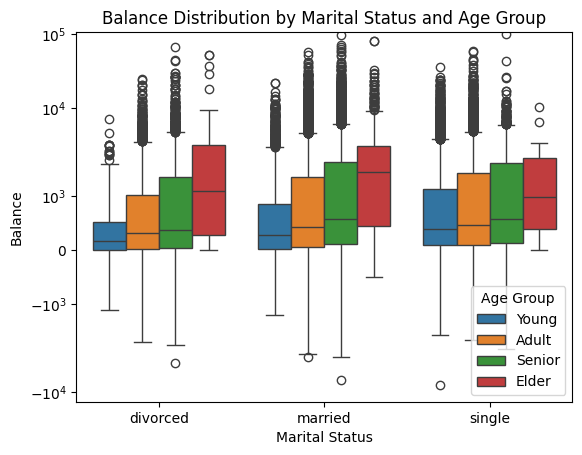

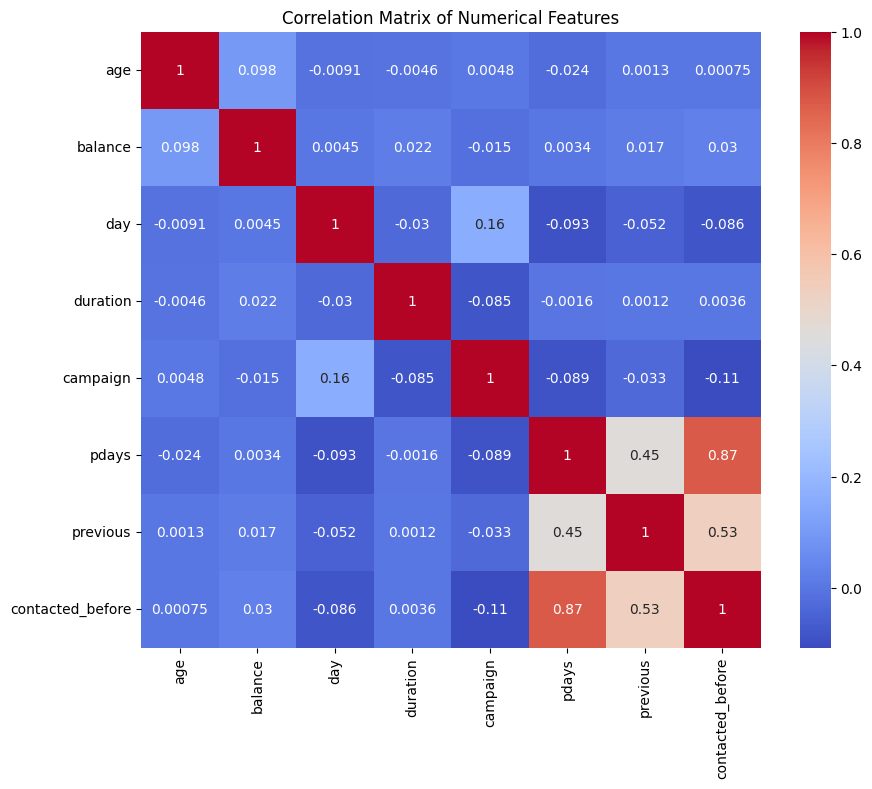

In [56]:
# Histogram of Age
plt.figure(figsize=(8,5))
sns.histplot(df_cleaned['age'], bins=20, kde=True)
plt.title('Age Distribution of Clients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Bar chart of Age Groups
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', data=df_cleaned, order=['Young', 'Adult', 'Senior', 'Elder'])
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

# Bar chart: Count of clients by job type
plt.figure(figsize=(10,5))
sns.countplot(x='job', data=df_cleaned, order=df_cleaned['job'].value_counts().index)
plt.title('Number of Clients by Job Type')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot: Balance by Marital Status and Age Group
# 1. Boxplot with symlog y-axis to compress tails
ax = sns.boxplot(
    x='marital', y='balance', hue='age_group',
    data=df_cleaned, order=['divorced','married','single'],
    whis=2.5
)
ax.set_yscale('symlog', linthresh=1500)  # tweak linthresh (e.g., 1000–3000)
ax.set_title('Balance Distribution by Marital Status and Age Group')
ax.set_xlabel('Marital Status'); ax.set_ylabel('Balance')
ax.legend(title='Age Group')

# Heatmap: Correlation matrix of numerical features
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [21]:
## 1.5 Data Preprocessing: Additional Data Transformations
# We drop irrelevant features, ensure consistent data types, and prepare the final dataset for modeling.

In [25]:
# Drop 'duration' (leakage-prone) and other irrelevant columns if needed
df_model = df_cleaned.drop(['duration'], axis=1)

# Replace 'unknown' with 'Not Provided' in all object and category columns
for col in df_model.select_dtypes(include=['object', 'category']).columns:
    df_model[col] = df_model[col].replace('unknown', 'Not Provided').astype(str)

# Check final structure
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               45211 non-null  int64 
 1   job               45211 non-null  object
 2   marital           45211 non-null  object
 3   education         45211 non-null  object
 4   default           45211 non-null  object
 5   balance           45211 non-null  int64 
 6   housing           45211 non-null  object
 7   loan              45211 non-null  object
 8   contact           45211 non-null  object
 9   day               45211 non-null  int64 
 10  month             45211 non-null  object
 11  campaign          45211 non-null  int64 
 12  pdays             45211 non-null  int64 
 13  previous          45211 non-null  int64 
 14  poutcome          45211 non-null  object
 15  y                 45211 non-null  object
 16  age_group         45211 non-null  object
 17  contacted_be

In [23]:
## 1.6 Data Encoding
# We apply one-hot encoding to nominal categorical variables and ensure all features are numeric for modeling.

In [ ]:
# Identify nominal categorical variables
nominal_cols = [col for col in df_model.columns if df_model[col].dtype == 'object' and col != 'y']
# Apply one-hot encoding
df_encoded = pd.get_dummies(df_model, columns=nominal_cols, drop_first=True)
# Encode target variable
df_encoded['y'] = (df_encoded['y'] == 'yes').astype(int)
# Check final structure and data types
print(df_encoded.info())
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   balance              45211 non-null  int64
 2   day                  45211 non-null  int64
 3   campaign             45211 non-null  int64
 4   pdays                45211 non-null  int64
 5   previous             45211 non-null  int64
 6   y                    45211 non-null  int64
 7   contacted_before     45211 non-null  int64
 8   job_admin.           45211 non-null  bool 
 9   job_blue-collar      45211 non-null  bool 
 10  job_entrepreneur     45211 non-null  bool 
 11  job_housemaid        45211 non-null  bool 
 12  job_management       45211 non-null  bool 
 13  job_retired          45211 non-null  bool 
 14  job_self-employed    45211 non-null  bool 
 15  job_services         45211 non-null  bool 
 16  job_student          4

,age,balance,day,campaign,pdays,previous,y,contacted_before,job_admin.,job_blue-collar,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,age_group_Elder,age_group_Senior,age_group_Young
0,58,2143,5,1,-1,0,0,0,False,False,...,True,False,False,False,False,False,False,False,True,False
1,44,29,5,1,-1,0,0,0,False,False,...,True,False,False,False,False,False,False,False,False,False
2,33,2,5,1,-1,0,0,0,False,False,...,True,False,False,False,False,False,False,False,False,False
3,47,1506,5,1,-1,0,0,0,False,True,...,True,False,False,False,False,False,False,False,True,False
4,33,1,5,1,-1,0,0,0,False,False,...,True,False,False,False,False,False,False,False,False,False


In [33]:
## Export the preprocessed data into a csv file called sibusiso_preprocessed_bank_data.csv
preprocess_output = df_encoded.copy()
preprocess_output.to_csv("sibusiso_preprocessed_bank_data.csv", index=False)

In [25]:
# Part 2 – Supervised Learning
# We train and compare classification models (Logistic Regression and Random Forest) to predict term deposit subscription.

In [81]:
# Split data into train and test sets
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# One-hot encode 'age_group' in train and test sets
X_train = pd.get_dummies(X_train, columns=['age_group'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['age_group'], drop_first=True)

# Ensure both train and test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Train Logistic Regression
start_lr = time.time()
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:,1]
lr_time = time.time() - start_lr

# Train Random Forest
start_rf = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]
rf_time = time.time() - start_rf

Logistic Regression Results:
Accuracy: 0.821
Precision: 0.663
Recall: 0.456
F1 Score: 0.540
ROC-AUC: 0.826
Computational Time: 0.563 seconds

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1207
           1       0.66      0.46      0.54       362

    accuracy                           0.82      1569
   macro avg       0.76      0.69      0.71      1569
weighted avg       0.81      0.82      0.81      1569

Random Forest Results:
Accuracy: 0.822
Precision: 0.655
Recall: 0.483
F1 Score: 0.556
ROC-AUC: 0.847
Computational Time: 0.780 seconds

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1207
           1       0.66      0.48      0.56       362

    accuracy                           0.82      1569
   macro avg       0.76      0.70      0.72      1569
weighted avg       0.81      0.82      0.81      1569



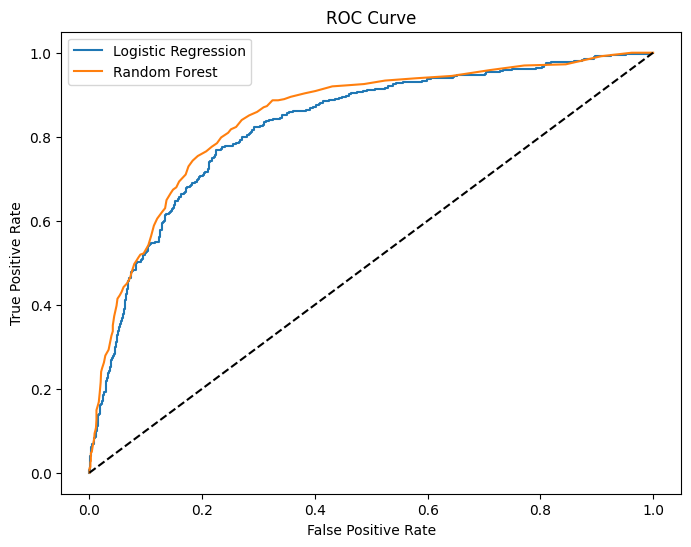

In [82]:
# Evaluate models
def print_metrics(name, y_true, y_pred, y_proba, elapsed):
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print(f"Computational Time: {elapsed:.3f} seconds\n")
    print(classification_report(y_true, y_pred))

print_metrics('Logistic Regression', y_test, lr_pred, lr_proba, lr_time)
print_metrics('Random Forest', y_test, rf_pred, rf_proba, rf_time)

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [28]:
# Insights and Conclusions
# - Data cleaning and feature engineering improved data quality and model performance.
# - Age group and prior contact are important predictors for term deposit subscription.
# - Random Forest generally outperforms Logistic Regression in accuracy and ROC-AUC.
# - Visualizations and correlation analysis help guide feature selection and modeling decisions.
# - The final dataset is numeric and model-ready, and all steps are documented for reproducibility.

# Assignment Scenario and Tasks
You are a junior data analyst for a South African bank. The goal is to explore and prepare historical marketing campaign data and assist in building a machine learning model to predict whether a client will subscribe to a term deposit.

**Assignment Tasks:**
- Data Preparation: Cleaning, feature categorization, engineering new features, statistics, correlations, visualizations, preprocessing, encoding.
- Supervised Learning: Train and compare classification models (Logistic Regression, Random Forest), evaluate with accuracy, precision, recall, F1, ROC-AUC, and computational time.

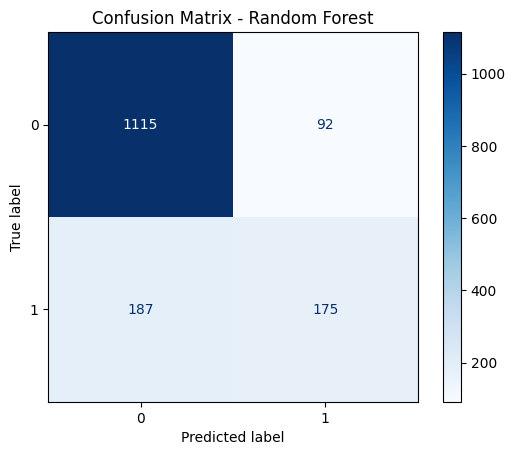

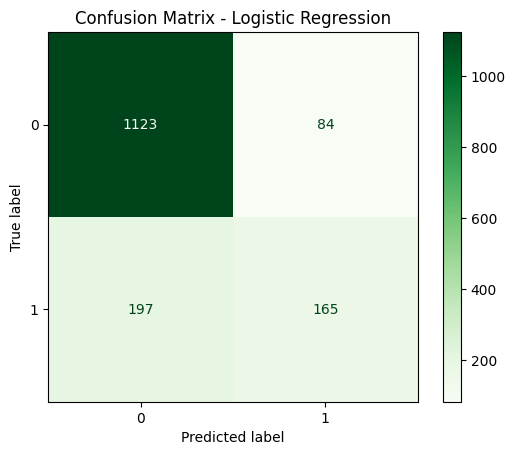

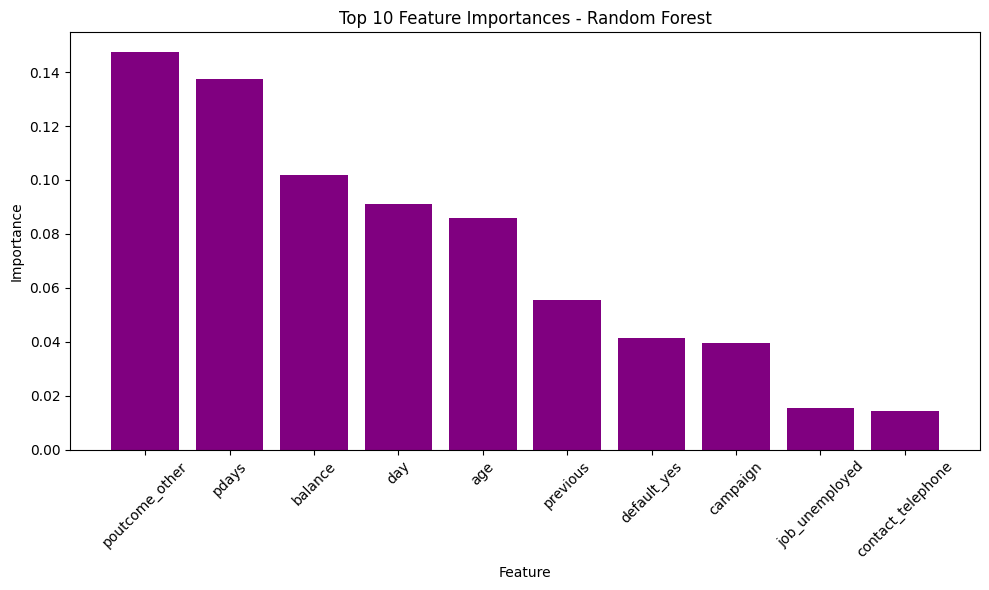

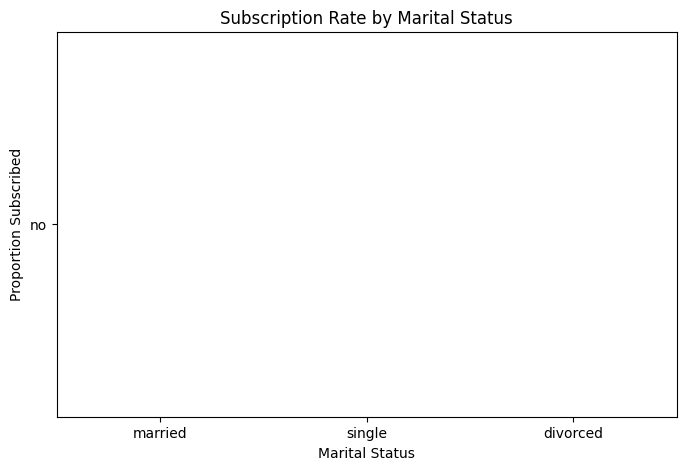

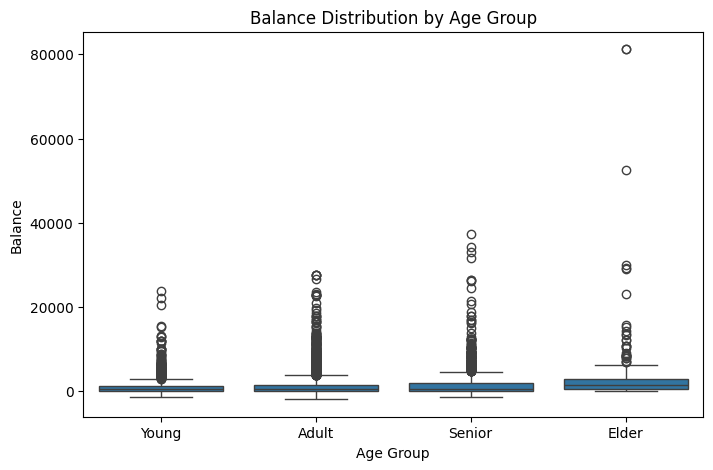

In [83]:
# Confusion Matrix for Random Forest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Bar graph: Feature importance (Random Forest)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar([X.columns[i] for i in indices[:10]], importances[indices[:10]], color='purple')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar graph: Subscription rate by marital status
plt.figure(figsize=(8,5))
sns.barplot(x='marital', y='y', data=df_cleaned, estimator=lambda x: np.mean(x=='yes'))
plt.title('Subscription Rate by Marital Status')
plt.ylabel('Proportion Subscribed')
plt.xlabel('Marital Status')
plt.show()

# Boxplot: Balance by Age Group
plt.figure(figsize=(8,5))
sns.boxplot(x='age_group', y='balance', data=df_cleaned)
plt.title('Balance Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Balance')
plt.show()